# Vault and account transfers



This notebook aims to provide a brief demonstration of how this codebase could be used for visualize vault and account transfers.

In [1]:
"""load dependencies and define constants"""
import sys
from enum import Enum
from decimal import Decimal

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from IPython.display import display

sys.path.append("..")
from src.yearn import Yearn, Subgraph
from src.utils.web3 import Web3Provider
from src.networks import Network

# constants
FROM_BLOCK = 13900000  # Dec-29-2021
TOP_COUNT = 10

class Stats(Enum):
    # top-level stats
    vaults = "vaults"
    overall_account_transfers = "overall_account_transfers"
    # sub stats
    count = "count"
    shares = "shares"
    shares_usdc = "shares_usdc"
    account_transfers = "account_transfers"

    def __repr__(self):
        return self.value

# Used to compare performances
metrics = [Stats.count, Stats.shares, Stats.shares_usdc]

pd.set_option("expand_frame_repr", False)

In [2]:
"""get current block, load vaults from the yearn instance and initialize subgraph instance"""
load_dotenv()
w3 = Web3Provider(Network.Mainnet)
current_block = w3.provider.eth.get_block("latest")["number"]
print(f"current block number: {current_block}")

yearn = Yearn(Network.Mainnet)
vaults = yearn.vaults
print(f"loaded metadata for {len(vaults)} vaults (v2)")

subgraph = Subgraph(Network.Mainnet)

current block number: 14982516
loaded metadata for 101 vaults (v2)


In [3]:
"""helper function to convert dict to reversed sorted dataframes"""
def to_sorted_df(_dict: dict[str, dict], ascending=False):
    stats = []
    for address, sub_dict in _dict.items():
        # only include address and items in metrics
        new_sub_dict = dict((k, v) for k, v in sub_dict.items() if k in metrics)
        stats.append((address, *new_sub_dict.values()))
    df = pd.DataFrame(stats, columns=["address", "count", "shares", "approx. USDC value"])
    df["approx. USDC value"] = pd.to_numeric(df["approx. USDC value"])
    df.set_index(keys=["address"], inplace=True)
    df.columns.name = df.index.name
    df.index.name = None
    df.sort_values("approx. USDC value", inplace=True, ascending=ascending)
    return df

In [4]:
"""helper function to plot top addresses in percentage"""
def plot_top_percent(df: pd.DataFrame, title: str, metric: str = "approx. USDC value") -> None:
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 8))
    plt.tick_params(labelbottom=False)
    plt.bar(df.index[:TOP_COUNT], df[metric].iloc[:TOP_COUNT].abs() / df[metric].abs().sum())
    plt.title(title)

    concentration = df[metric].iloc[:TOP_COUNT].abs().sum() / df[metric].abs().sum()
    print("Concentration: {:.2f}%".format(concentration * 100))

In [5]:
"""get vaults, accounts and overall accounts' stats for withdrawal"""
"""print stats for each vault and top accounts by shares_usdc for each vault"""
withdrawals_stats = {Stats.vaults: {}, Stats.overall_account_transfers: {}}
for idx, vault in enumerate(vaults):
    # approximate the share price by the current usdc value, skip if not available
    try:
        share_price = w3.get_usdc_price(vault.token.address)
    except:
        continue

    transfers = subgraph.vault_transfers("withdrawals", vault, from_block=FROM_BLOCK, to_block=current_block)

    # current vault's stats
    _dict = {
        Stats.count: transfers.count,
        Stats.shares: transfers.shares,
        Stats.shares_usdc: float(Decimal(transfers.shares) * share_price),
    }
    print(f"vault: {vault.address} {dict((k, v) for k, v in _dict.items() if k in _dict)}")

    account_items = transfers.account_transfers.items()
    sorted_account_transfers = sorted(account_items, key=lambda item: item[1].shares, reverse=True)
    account_transfers = {}
    
    # loop current vault's account_transfers
    for index, (account, transfer) in enumerate(sorted_account_transfers):
        # current vault's single account_transfers stat
        sub_dict = {
            Stats.count: transfer.count,
            Stats.shares: transfer.shares,
            Stats.shares_usdc: float(Decimal(transfer.shares) * share_price)
        }
        account_transfers[account] = sub_dict

        # print top accounts' stats for current vault
        if index < TOP_COUNT:
            print(f"{index}: {account} {sub_dict}")

        # add overall_account_transfers to withdrawals stats
        overall_account_transfers = withdrawals_stats[Stats.overall_account_transfers]
        if overall_account_transfers.get(account) is None:
            overall_account_transfers[account] = {}
        account_stats = overall_account_transfers[account]
        overall_account_transfers[account] = {k: account_stats.get(k, 0) + sub_dict[k] for k in sub_dict}

    # add vault's stats to withdrawals stats
    withdrawals_stats[Stats.vaults][vault.address] = {**_dict, Stats.account_transfers: account_transfers}
    print()

vault: 0x84E13785B5a27879921D6F685f041421C7F482dA {count: 92, shares: 15013654.476463575, shares_usdc: 15344420.298234545}
0: 0xec0ace67eee491c57fc81cf35e8d4c66062d1514 {count: 1, shares: 5603798.477580424, shares_usdc: 5727255.761839999}
1: 0x7d2ab9ca511ebd6f03971fb417d3492aa82513f0 {count: 5, shares: 2200000.0, shares_usdc: 2248468.2}
2: 0x02c4bc6b7dda908bf89bda10cf8dbb8649823284 {count: 1, shares: 1048530.7038029708, shares_usdc: 1071630.883738454}
3: 0xdb5ac83c137321da29a59a7592232bc4ed461730 {count: 1, shares: 963801.853279972, shares_usdc: 985035.3719095831}
4: 0x0d0b3a4fb611d11b044444ed2154cdcd7830d506 {count: 1, shares: 700528.9776926717, shares_usdc: 715962.3316002189}
5: 0xa391e2d6be511dc8646c3471bb32ecb436390915 {count: 1, shares: 631868.0966915111, shares_usdc: 645788.7827297217}
6: 0x67bc76e8fd78cc59594c9f43c643ea7cafa48669 {count: 1, shares: 509320.35112429626, shares_usdc: 520541.18777991564}
7: 0x0709b103d46d71458a71e5d81230dd688809a53d {count: 1, shares: 465309.4299459

In [6]:
"""top withdrawals for vaults"""
df = to_sorted_df(withdrawals_stats[Stats.vaults])
print(f"top withdrawals for {Stats.vaults} by approx. USDC value")
df.head(TOP_COUNT)

top withdrawals for Stats.vaults by approx. USDC value


address,count,shares,approx. USDC value
0xdA816459F1AB5631232FE5e97a05BBBb94970c95,1774,5.595270e+08,5.597793e+08
0x27b7b1ad7288079A66d12350c828D3C00A6F07d7,355,3.310601e+08,3.445799e+08
0xa258C4606Ca8206D8aA700cE2143D7db854D168c,1828,2.926846e+05,3.154701e+08
0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE,922,2.335738e+08,2.334103e+08
0xdCD90C7f6324cfa40d7169ef80b12031770B4325,1307,1.981466e+05,2.227292e+08
0xB4AdA607B9d6b2c9Ee07A275e9616B84AC560139,167,1.462793e+08,1.475370e+08
0x5f18C75AbDAe578b483E5F43f12a39cF75b973a9,963,1.148078e+08,1.147274e+08
0x7Da96a3891Add058AdA2E826306D812C638D87a7,571,8.935392e+07,8.926457e+07
0x3B96d491f067912D18563d56858Ba7d6EC67a6fa,488,8.165456e+07,8.679830e+07
0x2DfB14E32e2F8156ec15a2c21c3A6c053af52Be8,100,7.850019e+07,7.907065e+07


Concentration: 85.25%


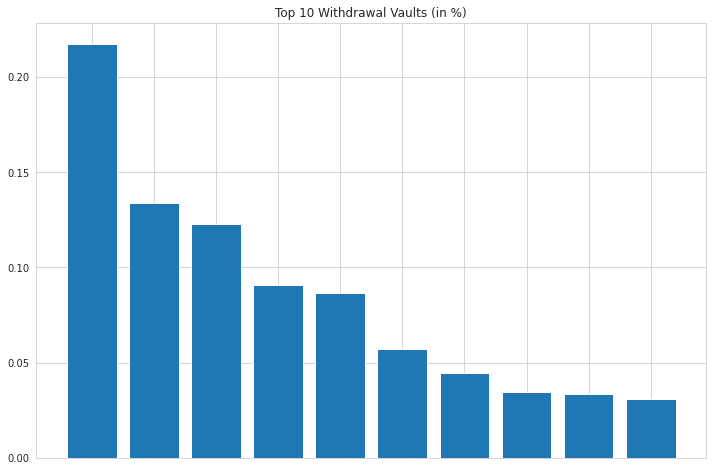

In [7]:
"""distribution of the top 10 withdrawal vaults"""
plot_top_percent(df, "Top 10 Withdrawal Vaults (in %)")

In [8]:
"""top withdrawals for overall account transfers"""
df = to_sorted_df(withdrawals_stats[Stats.overall_account_transfers])
print(f"top withdrawals for {Stats.overall_account_transfers.value.replace('_', ' ')} by approx. USDC value")
df.head(TOP_COUNT)

top withdrawals for overall account transfers by approx. USDC value


address,count,shares,approx. USDC value
0x6fe02be0ec79dcf582cbdb936d7037d2eb17f661,87,2.881235e+08,2.882534e+08
0xd6b88257e91e4e4d4e990b3a858c849ef2dfde8c,1841,5.161974e+07,2.216202e+08
0xb039ea6153c827e59b620bdcd974f7bbfe68214a,971,1.826064e+08,1.826888e+08
0x6d75657771256c7a8cb4d475fdf5047b70160132,154,1.002245e+05,1.080269e+08
0xdb91f52eefe537e5256b8043e5f7c7f44d81f5aa,12,1.303257e+10,1.034920e+08
0xa6d1c610b3000f143c18c75d84baa0ec22681185,29,9.857574e+07,1.026014e+08
0x0c8f62939aeee6376f5fac88f48a5a3f2cf5debb,35,9.510421e+07,9.898808e+07
0x0d5dc686d0a2abbfdafdfb4d0533e886517d4e83,1,5.629800e+07,5.670712e+07
0x65a8efc842d2ba536d3f781f504a1940f61124b4,13,5.118207e+07,5.327224e+07
0xf9fdc2b5f60355a237deb8bd62cc117b1c907f7b,20,4.640823e+04,5.216575e+07


Concentration: 49.28%


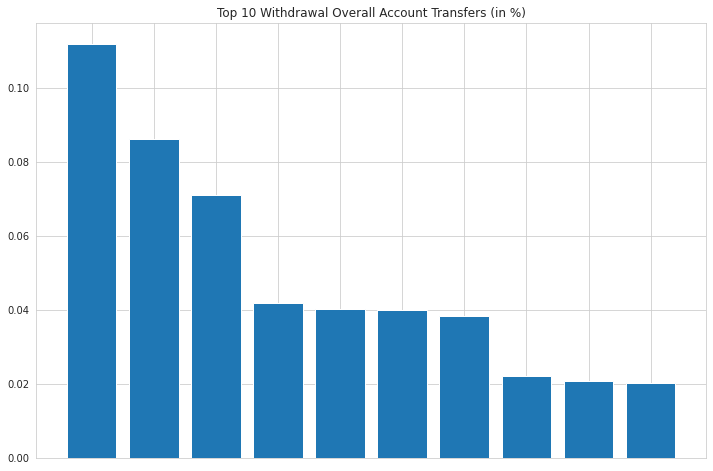

In [9]:
"""distribution of the top 10 withdrawal overall account transfers"""
plot_top_percent(df, "Top 10 Withdrawal Overall Account Transfers (in %)")

In [10]:
"""get vaults, accounts and overall accounts' stats for deposits"""
"""print stats for each vault and top accounts by shares_usdc for each vault"""
deposits_stats = {Stats.vaults: {}, Stats.overall_account_transfers: {}}
for idx, vault in enumerate(vaults):
    # approximate the share price by the current usdc value, skip if not available
    try:
        share_price = w3.get_usdc_price(vault.token.address)
    except:
        continue
    
    transfers = subgraph.vault_transfers("deposits", vault, from_block=FROM_BLOCK, to_block=current_block)

    # current vault's stats
    _dict = {
        Stats.count: transfers.count,
        Stats.shares: transfers.shares,
        Stats.shares_usdc: float(Decimal(transfers.shares) * share_price)
    }
    print(f"vault: {vault.address} {dict((k, v) for k, v in _dict.items() if k in _dict)}")

    account_items = transfers.account_transfers.items()
    sorted_account_transfers = sorted(account_items, key=lambda item: item[1].shares, reverse=True)
    account_transfers = {}
    
    # loop current vault's account_transfers
    for index, (account, transfer) in enumerate(sorted_account_transfers):
        # current vault's single account_transfers stat
        sub_dict = {
            Stats.count: transfer.count,
            Stats.shares: transfer.shares,
            Stats.shares_usdc: float(Decimal(transfer.shares) * share_price)
        }
        account_transfers[account] = sub_dict
        
        # print top accounts' stats for current vault
        if index < TOP_COUNT:
            print(f"{index}: {account} {sub_dict}")

        # add overall_account_transfers to deposits stats
        overall_account_transfers = deposits_stats[Stats.overall_account_transfers]
        if overall_account_transfers.get(account) is None:
            overall_account_transfers[account] = {}
        account_stats = overall_account_transfers[account]
        overall_account_transfers[account] = {k: account_stats.get(k, 0) + sub_dict[k] for k in sub_dict}

    # add vault's stats to deposits stats
    deposits_stats[Stats.vaults][vault.address] = {**_dict, Stats.account_transfers: account_transfers}
    print()

vault: 0x84E13785B5a27879921D6F685f041421C7F482dA {count: 33, shares: 297585.32873681874, shares_usdc: 304141.4311142196}
0: 0x69b9a89083e2324079922e01557cafb87cd90b09 {count: 2, shares: 256214.23452685837, shares_usdc: 261858.8903277196}
1: 0x59af1dd411e4e677e7555a9ea99abb8b2a82147f {count: 1, shares: 13342.067593373737, shares_usdc: 13636.006684523354}
2: 0x833ad4b1d1e64743dc16f1eaf4bc0b5a85b4b9fc {count: 1, shares: 11850.821486772404, shares_usdc: 12111.906934947487}
3: 0x579422a1c774470ca623329c69f27cc3beb935a1 {count: 2, shares: 4613.065778579662, shares_usdc: 4714.6962307475505}
4: 0x656ab7cdf51230934752f87ff3cad0d78fe59940 {count: 1, shares: 2764.5064794620885, shares_usdc: 2825.4113217111176}
5: 0x027b6146248b3a7648e7c7e243bd01e1704bc3ca {count: 1, shares: 1925.716982133382, shares_usdc: 1968.1424529667627}
6: 0x6512cbdad4d76ff79d3e96ace168f2e1315c1ece {count: 1, shares: 1246.1617464059173, shares_usdc: 1273.615935840986}
7: 0x3f1b8bc4a73b5a65e420076ecb8690f0eab78ec4 {count: 1,

In [11]:
"""top deposits for vaults"""
df = to_sorted_df(deposits_stats[Stats.vaults])
print(f"top deposits for {Stats.vaults} by approx. USDC value")
df.head(TOP_COUNT)

top deposits for Stats.vaults by approx. USDC value


address,count,shares,approx. USDC value
0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE,2781,4.435875e+08,4.427451e+08
0xdA816459F1AB5631232FE5e97a05BBBb94970c95,1450,3.062627e+08,3.064009e+08
0xa258C4606Ca8206D8aA700cE2143D7db854D168c,3978,1.847170e+05,1.990973e+08
0x27b7b1ad7288079A66d12350c828D3C00A6F07d7,188,1.731556e+08,1.802269e+08
0xdCD90C7f6324cfa40d7169ef80b12031770B4325,1340,1.297337e+05,1.458288e+08
0xB4AdA607B9d6b2c9Ee07A275e9616B84AC560139,110,8.031713e+07,8.100769e+07
0x7Da96a3891Add058AdA2E826306D812C638D87a7,885,6.876278e+07,6.852933e+07
0x5faF6a2D186448Dfa667c51CB3D695c7A6E52d8E,252,6.266090e+04,6.782223e+07
0x67e019bfbd5a67207755D04467D6A70c0B75bF60,294,4.483668e+07,4.755356e+07
0x2DfB14E32e2F8156ec15a2c21c3A6c053af52Be8,82,4.670257e+07,4.704205e+07


Concentration: 90.23%


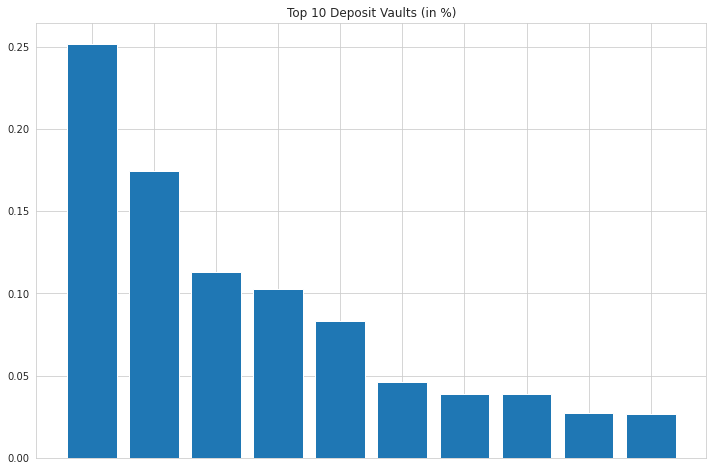

In [12]:
"""distribution of the top 10 deposit vaults"""
plot_top_percent(df, "Top 10 Deposit Vaults (in %)")

In [13]:
"""top deposits for overall_account_transfers"""
df = to_sorted_df(deposits_stats[Stats.overall_account_transfers])
print(f"top deposits for {Stats.overall_account_transfers.value.replace('_', ' ')} by approx. USDC value")
df.head(TOP_COUNT)

top deposits for overall account transfers by approx. USDC value


address,count,shares,approx. USDC value
0x92be6adb6a12da0ca607f9d87db2f9978cd6ec3e,2840,8.403113e+07,1.547443e+08
0xcc323557c71c0d1d20a1861dc69c06c5f3cc9624,25,1.545131e+08,1.542196e+08
0x6fe02be0ec79dcf582cbdb936d7037d2eb17f661,48,9.170115e+07,9.174250e+07
0x36822d0b11f4594380181ce6e76bd4986d46c389,20,9.159970e+07,9.142576e+07
0x0c8f62939aeee6376f5fac88f48a5a3f2cf5debb,29,8.461024e+07,8.806556e+07
0xb039ea6153c827e59b620bdcd974f7bbfe68214a,14,7.884207e+07,7.887763e+07
0x8e52522e6a77578904ddd7f528a22521dc4154f5,2039,5.251001e+06,6.262063e+07
0xcde35b62c27d70b279cf7d0aa1212ffa9e938cef,1,4.088267e+04,4.425014e+07
0xd96f48665a1410c0cd669a88898eca36b9fc2cce,155,4.314900e+07,4.332986e+07
0xdb91f52eefe537e5256b8043e5f7c7f44d81f5aa,8,3.069951e+07,3.977063e+07


Concentration: 48.30%


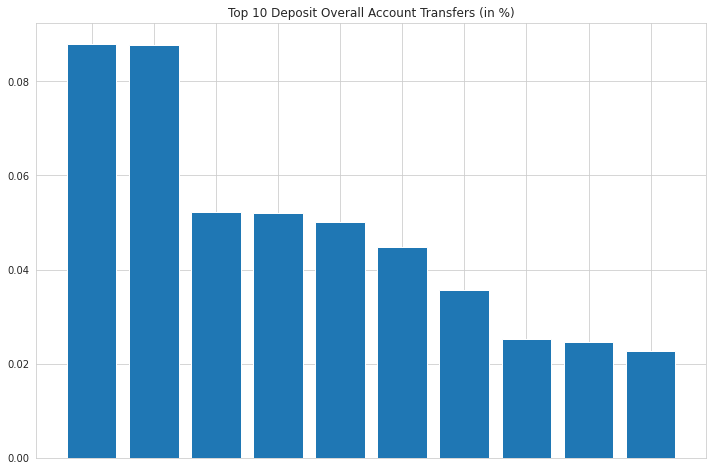

In [14]:
"""distribution of the top 10 deposit overall account transfers"""
plot_top_percent(df, "Top 10 Deposit Overall Account Transfers (in %)")

In [15]:
"""helper functions to calculate net transfers"""

def equalize_lists(*args: list[tuple]) -> None:
    """Make all lists equal in size"""
    items = [*args]
    max_length = 0
    for item in items:
        max_length = max(max_length, len(item))
    for item in items:
        item += [(None, None)] * (max_length - len(item))

def get_net_transfer(withdrawals_items: list[tuple[str, dict]], deposits_items: list[tuple[str, dict]]) -> dict[str, dict[str, float]]:
    """Get net transfer of vaults and overall account transfers"""
    net_transfer = {}

    for (withdraw_address, withdraw_stats), (deposit_address, deposit_stats) in zip(withdrawals_items, deposits_items):
        if withdraw_address is not None:
            if net_transfer.get(withdraw_address) is None:
                net_transfer[withdraw_address] = {}
            _dict = {}
            for k in metrics:
                if k == Stats.count:
                    _dict[k] = net_transfer[withdraw_address].get(k, 0) + withdraw_stats[k]
                else:
                    _dict[k] = net_transfer[withdraw_address].get(k, 0) - withdraw_stats[k]
            net_transfer[withdraw_address] = _dict
        if deposit_address is not None:
            if net_transfer.get(deposit_address) is None:
                net_transfer[deposit_address] = {}
            net_transfer[deposit_address] = {k: net_transfer[deposit_address].get(k, 0) + deposit_stats[k] for k in metrics}

    return net_transfer

In [16]:
"""get net inflow transfer of each vault's item in metrics"""
withdrawals_vaults = list(withdrawals_stats[Stats.vaults].items())
deposits_vaults = list(deposits_stats[Stats.vaults].items())
equalize_lists(withdrawals_vaults, deposits_vaults)
net_vaults = get_net_transfer(withdrawals_vaults, deposits_vaults)

"""top net inflow transfer for vaults"""
df = to_sorted_df(net_vaults)
print(f"top net inflow transfer for vaults by approx. USDC value")
df.head(TOP_COUNT)

top net inflow transfer for vaults by approx. USDC value


address,count,shares,approx. USDC value
0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE,3703,2.100137e+08,2.093348e+08
0x595a68a8c9D5C230001848B69b1947ee2A607164,125,1.193290e+07,1.462345e+07
0xF59D66c1d593Fb10e2f8c2a6fD2C958792434B9c,17,1.103217e+07,1.131536e+07
0x5faF6a2D186448Dfa667c51CB3D695c7A6E52d8E,347,5.953186e+03,6.443545e+06
0xd88dBBA3f9c4391Ee46f5FF548f289054db6E51C,149,2.155574e+06,2.215885e+06
0x5c0A86A32c129538D62C106Eb8115a8b02358d57,611,1.211188e+03,1.311293e+06
0x5AB64C599FcC59f0f2726A300b03166A395578Da,27,1.216129e+06,1.279646e+06
0x2D5D4869381C4Fce34789BC1D38aCCe747E295AE,28,9.881192e+05,9.875668e+05
0x132d8D2C76Db3812403431fAcB00F3453Fc42125,30,8.089265e+02,9.115283e+05
0x6A5468752f8DB94134B6508dAbAC54D3b45efCE6,202,9.294455e+03,5.041297e+05


Concentration: 18.92%


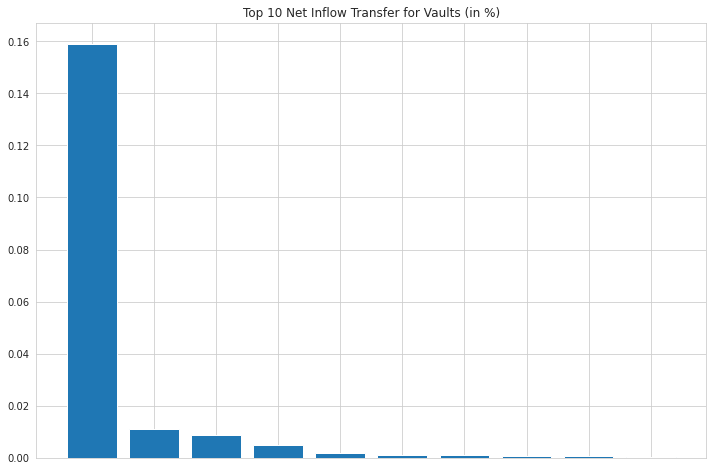

In [17]:
"""distribution of the top 10 inflow net transfer for vaults"""
plot_top_percent(df, "Top 10 Net Inflow Transfer for Vaults (in %)")

In [18]:
"""get net outflow transfer of each vault's item in metrics"""
withdrawals_vaults = list(withdrawals_stats[Stats.vaults].items())
deposits_vaults = list(deposits_stats[Stats.vaults].items())
equalize_lists(withdrawals_vaults, deposits_vaults)
net_vaults = get_net_transfer(withdrawals_vaults, deposits_vaults)

"""top net outflow transfer for vaults"""
df = to_sorted_df(net_vaults, ascending=True)
print(f"top net outflow transfer for vaults by approx. USDC value")
df.head(TOP_COUNT)

top net outflow transfer for vaults by approx. USDC value


address,count,shares,approx. USDC value
0xdA816459F1AB5631232FE5e97a05BBBb94970c95,3224,-2.532642e+08,-2.533784e+08
0x27b7b1ad7288079A66d12350c828D3C00A6F07d7,543,-1.579045e+08,-1.643530e+08
0xa258C4606Ca8206D8aA700cE2143D7db854D168c,5806,-1.079676e+05,-1.163728e+08
0x5f18C75AbDAe578b483E5F43f12a39cF75b973a9,1099,-1.057705e+08,-1.057036e+08
0xdCD90C7f6324cfa40d7169ef80b12031770B4325,2647,-6.841290e+04,-7.690037e+07
0xB4AdA607B9d6b2c9Ee07A275e9616B84AC560139,277,-6.596220e+07,-6.652934e+07
0x3B96d491f067912D18563d56858Ba7d6EC67a6fa,755,-5.100524e+07,-5.421827e+07
0x2DfB14E32e2F8156ec15a2c21c3A6c053af52Be8,182,-3.179762e+07,-3.202860e+07
0xA74d4B67b3368E83797a35382AFB776bAAE4F5C8,89,-2.160411e+07,-2.158783e+07
0xA696a63cc78DfFa1a63E9E50587C197387FF6C7E,525,-1.022121e+03,-2.087945e+07


Concentration: 69.30%


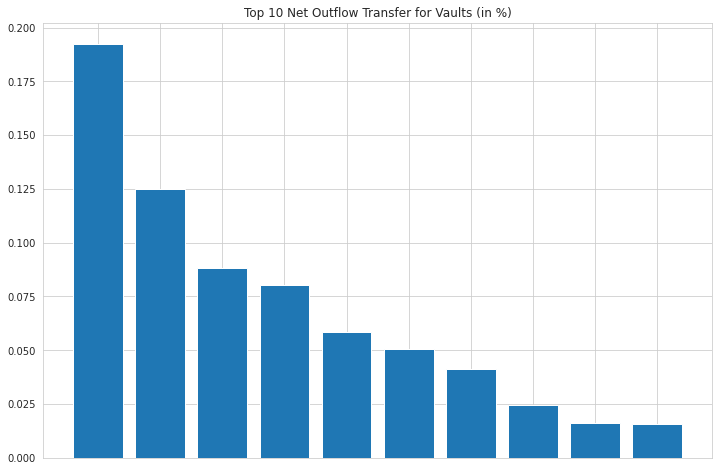

In [19]:
"""distribution of the top 10 net outflow transfer for vaults"""
plot_top_percent(df, "Top 10 Net Outflow Transfer for Vaults (in %)")

In [20]:
"""get net inflow transfer of each account's item in metrics scoped by all vaults"""
withdrawals_account_transfers = list(withdrawals_stats[Stats.overall_account_transfers].items())
deposits_account_transfers = list(deposits_stats[Stats.overall_account_transfers].items())
equalize_lists(withdrawals_account_transfers, deposits_account_transfers)
net_overall_account_transfers = get_net_transfer(withdrawals_account_transfers, deposits_account_transfers)

"""top net inflow transfer for account transfers scoped by all vaults"""
df = to_sorted_df(net_overall_account_transfers)
print(f"top net inflow transfer for account transfers scoped by all vaults by approx. USDC value")
df.head(TOP_COUNT)

top net inflow transfer for account transfers scoped by all vaults by approx. USDC value


address,count,shares,approx. USDC value
0x92be6adb6a12da0ca607f9d87db2f9978cd6ec3e,2840,8.403113e+07,1.547443e+08
0xcc323557c71c0d1d20a1861dc69c06c5f3cc9624,25,1.545131e+08,1.542196e+08
0x36822d0b11f4594380181ce6e76bd4986d46c389,20,9.159970e+07,9.142576e+07
0x8e52522e6a77578904ddd7f528a22521dc4154f5,2039,5.251001e+06,6.262063e+07
0xd96f48665a1410c0cd669a88898eca36b9fc2cce,155,4.314900e+07,4.332986e+07
0xa0f75491720835b36edc92d06ddc468d201e9b73,4,2.565635e+07,2.798884e+07
0xf5bce5077908a1b7370b9ae04adc565ebd643966,95,2.457683e+07,2.668772e+07
0xb3295e739380bd68de96802f7c4dba4e54477206,127,1.641976e+04,1.845684e+07
0x5c6374a2ac4ebc38dea0fc1f8716e5ea1add94dd,368,1.812083e+07,1.811254e+07
0x62d9855c399fde8226840ea12d9f1dd693a49b6a,1017,1.787526e+07,1.784132e+07


Concentration: 24.44%


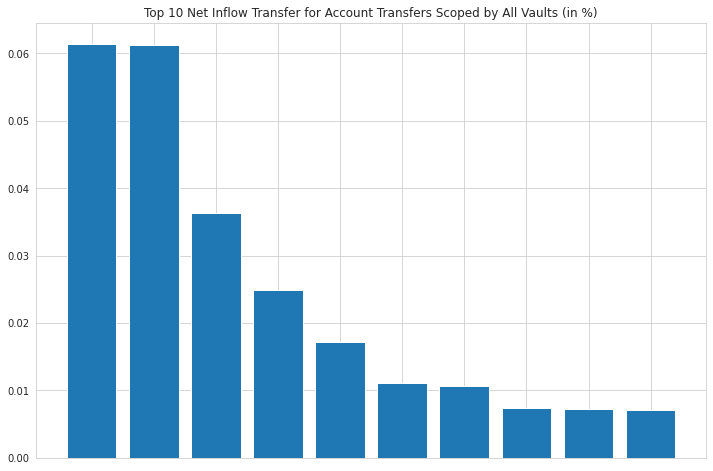

In [21]:
"""distribution of the top 10 net inflow transfer for account transfers scoped by all vaults"""
plot_top_percent(df, "Top 10 Net Inflow Transfer for Account Transfers Scoped by All Vaults (in %)")

In [22]:
"""get net outflow transfer of each account's item in metrics scoped by all vaults"""
withdrawals_account_transfers = list(withdrawals_stats[Stats.overall_account_transfers].items())
deposits_account_transfers = list(deposits_stats[Stats.overall_account_transfers].items())
equalize_lists(withdrawals_account_transfers, deposits_account_transfers)
net_overall_account_transfers = get_net_transfer(withdrawals_account_transfers, deposits_account_transfers)

"""top net outflow transfer for account transfers scoped by all vaults"""
df = to_sorted_df(net_overall_account_transfers, ascending=True)
print(f"top net outflow transfer for account transfers scoped by all vaults by approx. USDC value")
df.head(TOP_COUNT)

top net outflow transfer for account transfers scoped by all vaults by approx. USDC value


address,count,shares,approx. USDC value
0xd6b88257e91e4e4d4e990b3a858c849ef2dfde8c,1841,-5.161974e+07,-2.216202e+08
0x6fe02be0ec79dcf582cbdb936d7037d2eb17f661,135,-1.964223e+08,-1.965109e+08
0xb039ea6153c827e59b620bdcd974f7bbfe68214a,985,-1.037643e+08,-1.038111e+08
0x6d75657771256c7a8cb4d475fdf5047b70160132,405,-7.816955e+04,-8.425504e+07
0xa6d1c610b3000f143c18c75d84baa0ec22681185,40,-6.904466e+07,-7.186430e+07
0xdb91f52eefe537e5256b8043e5f7c7f44d81f5aa,20,-1.300187e+10,-6.372140e+07
0xf9fdc2b5f60355a237deb8bd62cc117b1c907f7b,29,-3.830035e+04,-4.305198e+07
0x65a8efc842d2ba536d3f781f504a1940f61124b4,22,-3.617668e+07,-3.765406e+07
0x0d5dc686d0a2abbfdafdfb4d0533e886517d4e83,4,-3.237516e+07,-3.261039e+07
0x5f8f52ddc15990a45ba5aab85dfd9fdfae11b661,2,-2.882991e+04,-3.240662e+07


Concentration: 35.25%


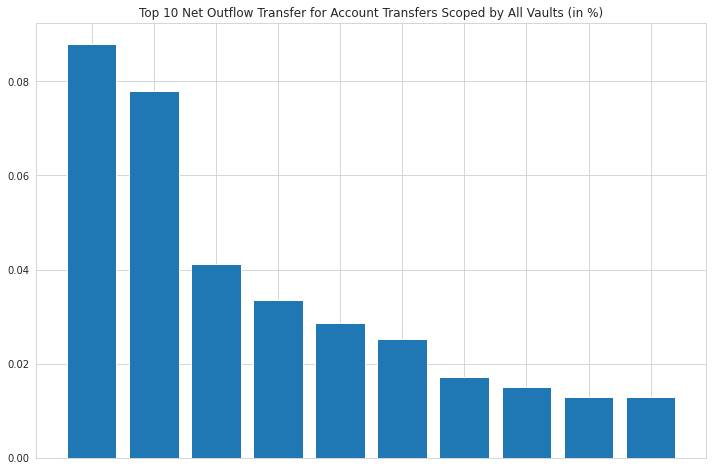

In [23]:
"""distribution of the top 10 net outflow transfer for account transfers scoped by all vaults"""
plot_top_percent(df, "Top 10 Net Outflow Transfer for Account Transfers Scoped by All Vaults (in %)")

In [24]:
"""get net transfer of each vault's account's item in metrics scoped by each vault"""
net_transfer = {}
for (withdraw_address, withdraw_stats), (deposit_address, deposit_stats) in zip(withdrawals_vaults, deposits_vaults):
    if withdraw_address is not None:
        if net_transfer.get(withdraw_address) is None:
            net_transfer[withdraw_address] = {}

        for (account, account_transfer) in list(withdraw_stats[Stats.account_transfers].items()):
            if net_transfer[withdraw_address].get(account) is None:
                net_transfer[withdraw_address][account] = {}
            _dict = {}
            for k in metrics:
                if k == Stats.count:
                    _dict[k] = net_transfer[withdraw_address][account].get(k, 0) + account_transfer[k]
                else:
                    _dict[k] = net_transfer[withdraw_address][account].get(k, 0) - account_transfer[k]
            net_transfer[withdraw_address][account] = _dict
        
    if deposit_address is not None:
        if net_transfer.get(deposit_address) is None:
            net_transfer[deposit_address] = {}

        for (account, account_transfer) in list(deposit_stats[Stats.account_transfers].items()):
            if net_transfer[deposit_address].get(account) is None:
                net_transfer[deposit_address][account] = {}
            account_val = {k: net_transfer[deposit_address][account].get(k, 0) + account_transfer[k] for k in metrics}
            net_transfer[deposit_address][account] = account_val

In [25]:
"""top net inflow transfer for each vault's accounts"""
for vault_address, account_transfers in net_transfer.items():
    df = to_sorted_df(account_transfers)
    print(f"top net inflow transfer for accounts in vault {vault_address} by approx. USDC value")
    print(df.head(TOP_COUNT))
    print()

top net inflow transfer for accounts in vault 0x84E13785B5a27879921D6F685f041421C7F482dA by approx. USDC value
address                                     count         shares  approx. USDC value
0x69b9a89083e2324079922e01557cafb87cd90b09      2  256214.234527       261858.890328
0x59af1dd411e4e677e7555a9ea99abb8b2a82147f      3    7060.146183         7215.688264
0x579422a1c774470ca623329c69f27cc3beb935a1      2    4613.065779         4714.696231
0x656ab7cdf51230934752f87ff3cad0d78fe59940      1    2764.506479         2825.411322
0x6512cbdad4d76ff79d3e96ace168f2e1315c1ece      1    1246.161746         1273.615936
0xe66ac3d00b7a8f7056406a708455e14f1762ef47      1     797.852956          815.430455
0x6fa38e4e778ce8d05d813b742965894719d2edd5      2     300.406684          307.024944
0xabe521ec7ea3b0e95ef2db9c9ad1079a421382b8      1     187.889857          192.029259
0x808e961df1ede82153374b5be64a4a7b46873010      1      19.034711           19.454065
0x8e52522e6a77578904ddd7f528a22521dc415

In [26]:
"""top net outflow transfer for each vault's accounts"""
for vault_address, account_transfers in net_transfer.items():
    df = to_sorted_df(account_transfers, ascending=True)
    print(f"top net outflow transfer for accounts in vault {vault_address} by approx. USDC value")
    print(df.head(TOP_COUNT))
    print()

top net outflow transfer for accounts in vault 0x84E13785B5a27879921D6F685f041421C7F482dA by approx. USDC value
address                                     count        shares  approx. USDC value
0xec0ace67eee491c57fc81cf35e8d4c66062d1514      1 -5.603798e+06       -5.727256e+06
0x7d2ab9ca511ebd6f03971fb417d3492aa82513f0      5 -2.200000e+06       -2.248468e+06
0x02c4bc6b7dda908bf89bda10cf8dbb8649823284      1 -1.048531e+06       -1.071631e+06
0xdb5ac83c137321da29a59a7592232bc4ed461730      1 -9.638019e+05       -9.850354e+05
0x0d0b3a4fb611d11b044444ed2154cdcd7830d506      1 -7.005290e+05       -7.159623e+05
0xa391e2d6be511dc8646c3471bb32ecb436390915      1 -6.318681e+05       -6.457888e+05
0x67bc76e8fd78cc59594c9f43c643ea7cafa48669      1 -5.093204e+05       -5.205412e+05
0x0709b103d46d71458a71e5d81230dd688809a53d      1 -4.653094e+05       -4.755607e+05
0xae8453d0d4c581dec82dab0ff1c5048690bd6c12      1 -3.908916e+05       -3.995034e+05
0xbffbacd99b3b52e698b9c17e03faf89fcef475e9      